### Implementation of k-nearest neighbour

In [2]:
import numpy as np
import pandas as pd
import os
from collections import Counter #to count occurences
from abc import ABC, abstractmethod
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import random
random.seed(42)

Link to the Dataset: href=https://www.kaggle.com/datasets/rodolfomendes/abalone-dataset 

> KNN is a regression or classification, non-parametric, supervised machine learning algorithm.
> 
> It is mostly used for classification purposes.
> 
> Proximity is important hence scaling the data using minmax normalization is important.
> 
> The algorithm does not need to be trained, what is important is the training data that can be used for "lazy learning".
> 
> Optimal value for K should be selected using K-fold cross-validation.

In [5]:
# Interface for distance using strategic pattern (behavioural object-oriented design pattern)

class knnDistance(ABC):
    
    '''A templete for distance calculation'''
    
    @abstractmethod
    def calculation(self, x1, x2):
        pass
    
#Interface for Voting
class knnVoting(ABC):
    
    '''A template for Voting strategy'''
    
    @abstractmethod
    def voting(self, lebels):
        pass



In [6]:
# Implement the concrete representation of the knnDistance abstract class

class EuclideanDistance(knnDistance):
    
    '''Measures the distance between two datapoints'''
    
    def calculation(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2)**2))
    
###############################################

# Implement the concreate representation of knnVoting abstract class

class MajorityVoting(knnVoting):
    
    '''Takes the most popular datapoint'''
    
    def voting(self, labels):
        return Counter(labels).most_common(1)[0][0] 
    
# The concrete implementation of the distance and voting 
# class can be furthered to accommodate more implementation of distance calculation and 
# voting strategies 

In [7]:
# kNN classifier class
random.seed(42)
class kNNClassifier:
    def __init__(self, k=None, distance_strategy=None, voting_strategy=None):
        
        '''Initialization'''
        
        self.k = k
        self.distance_strategy = EuclideanDistance()
        self.voting_strategy = MajorityVoting()
    
    def load_data(self, file_path):
        
        ''' Finds the extension of the file'''
        
        file_extension = os.path.splitext(file_path)[1]
        
        if file_extension == '.csv':
            self.data = pd.read_csv(file_path)
        elif file_extension in ['.xls', 'xlsx']:
            self.data = pd.read_excel(file_path)
        elif file_extension == '.json':
            self.data = pd.read_json(file_path)
        else:
            raise ValueError(f'Unsupported file format: {file_extension}')
        return self.data 

    def y_data(self, target_value): # creates the y_data

        '''Isolates the target column from the training dataset.'''
        
        y= self.data[target_value]
        y = y.replace({'F': 0, 'I': 1, 'M': 0})
        return y.values
    
    def X_data(self,to_drop_value):
        
        '''The independent variables of the dataset.'''
        
        X=self.data.drop(columns=[to_drop_value]).values
        return X
    
    def data_split(self, X, y, test_size=0.2, shuffle=True):
        
        '''Splits the dataset into train and test datapoints'''
        
        if shuffle==True:
            indices = np.arange(X.shape[0])
            np.random.shuffle(indices)
            X = X[indices]
            y = y[indices]
            
        split_index = int(X.shape[0] * (1 - test_size))
        X_train, X_test = X[:split_index], X[split_index:]
        y_train, y_test = y[:split_index], y[split_index:]
        
        return X_train, X_test, y_train, y_test
            
        
    
    def fit(self, X_train, y_train):
        
        '''Fits the training and target columns for prediction.'''
        
        self.X_train = X_train 
        self.y_train = y_train
        
    def predict(self, X_test):

        '''Used as an interface for the predict function'''
        
        prediction = [self._predict(x) for x in X_test]
        return np.array(prediction)
    
    def _predict(self, x):
        
        distance = [self.distance_strategy.calculation(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distance)[:self.k]
        k_nearest = [self.y_train[i] for i in k_indices]
        
        return self.voting_strategy.voting(k_nearest)

    def cross_validation_k(self,X, y, k_values, cv=2):

        '''K-fold validation for selecting the optimal K value'''
        
        best_k = None
        best_score = 0
        scores =[]

        for k in k_values:
            self.k = k
            kf = KFold(n_splits=cv, shuffle=True, random_state=42)
            cv_scores = []

            for train_index, val_index in kf.split(X):
                X_train, X_val = X[train_index], X[val_index]
                y_train, y_val = y[train_index], y[val_index]
                self.fit(X_train, y_train)
                y_pred = self.predict(X_val)
                accuracy = np.mean(y_pred == y_val)
                print (f'Accuracy:{accuracy}')
                cv_scores.append(accuracy)
                print(f'CV Scores {cv_scores}')

            avg_score = np.mean(cv_scores)
            scores.append(avg_score)

            if avg_score > best_score:
                best_score = avg_score
                best_k = k
                print(f'k_value: {k_values}')
                print(f'scores: {scores}')
            
       


        plt.figure(figsize=(10, 6))
        plt.plot(list(k_values), scores, marker='o', linestyle='-', color='b')
        plt.title('Cross-Validation Accuracy for Different k values in KNN')
        plt.xlabel('Number of Neighbors: k')
        plt.ylabel('Cross-Validation Accuracy')
        plt.xticks(np.arange(min(k_value), max(k_value)+1, 1))
        plt.grid()
        plt.show()

        print(f"Best k: {best_k} with Cross-Validation Accuracy: {best_score:.4f}")
        return best_k

In [8]:
# Evaluation of the prediction 

class ConfusionMatrix:
    def __init__(self, true_labels, predicted_labels, classes=None):
        
        '''Initiation of the ConfusionMatrix objects.'''
        
        self.true_labels = true_labels 
        self.predicted_labels = predicted_labels
        #take the two labels, concatenate them into one array and take the unique classes (output==0 and 1)
        self.classes = np.unique(np.concatenate((self.true_labels, self.predicted_labels)))
        self.matrix = None

    
    def confusion_matrix(self):
        
        '''Calculates the confusion matrix by comparing the true and predicted labels.'''
        
        num_classes = len(self.classes) #output == 2
        int_matrix = np.zeros((num_classes, num_classes), dtype=int) 

        for i, true_class in enumerate(self.classes): #raw
            for j, pred_class in enumerate(self.classes): #column
                int_matrix[i,j] = np.sum((self.true_labels == true_class) & (self.predicted_labels == pred_class))
        self.matrix = int_matrix
        
        import matplotlib.pyplot as plt
        
        plt.matshow(int_matrix, cmap='OrRd', fignum=1)
        plt.colorbar()
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        
        for (i, j), value in np.ndenumerate(int_matrix):
            plt.text(j, i, f'{value}')

        plt.show()
        print(self.matrix)
        return int_matrix
        

    def accuracy(self):
        
        ''' Calculates the accuracy of the prediction. '''
        
        # (TP + TN) / (TP + TN + PF + FN) # looks only the correct predictions
        
        # if the confusion matrix is not called
        if self.matrix is None:
            self.confusion_matrix()

        TP = np.trace(self.matrix) #adds the positive predictions (diagonally)
        total = np.sum(self.matrix)
        self.accuracy = TP/total
        return self.accuracy.round(3)

    def recall(self):
        '''Calcuates recall for each class. '''
    # TP / (TP + FN) # Type 2 Error: False Negative 
        
     # if the confusion matrix is not called
        
        if self.matrix is None:
            self.confusion_matrix()
            
        TP = self.matrix[1][1] 
        FN = self.matrix[1][0]
        self.r = TP / (TP + FN) if (TP + FN) > 0 else 0
        return self.r

    def precision(self):
        
        '''Calculates precision for each class '''

        # TP / (TP + FP) #Type 1 Error: False Positive
        
        # if the confusion matrix is not called
        if self.matrix is None:
            self.confusion_matrix()

        TP = self.matrix[1][1]
        FP = self.matrix[0][1]            
        self.prec = TP / (TP + FP) if (TP + FP) > 0 else 0            
        return self.prec    

    def f1_score(self):

        # call the functions that are needed to calculate F1 score 
        prec = self.precision()
        rec = self.recall()
        self.score = (2 * prec * rec) / (prec + rec) 
        return self.score
        

In [9]:
#Initiate the class
knn = kNNClassifier()

#load the data
knn.load_data('abalone.csv')


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [10]:
#get the target column

y = knn.y_data('Sex')
y

C:\Users\tes2s\AppData\Local\Temp\ipykernel_29784\2740382730.py:33: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({'F': 0, 'I': 1, 'M': 0})


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [11]:
#get the independent variables
X = knn.X_data('Sex')
X               

array([[ 0.455 ,  0.365 ,  0.095 , ...,  0.101 ,  0.15  , 15.    ],
       [ 0.35  ,  0.265 ,  0.09  , ...,  0.0485,  0.07  ,  7.    ],
       [ 0.53  ,  0.42  ,  0.135 , ...,  0.1415,  0.21  ,  9.    ],
       ...,
       [ 0.6   ,  0.475 ,  0.205 , ...,  0.2875,  0.308 ,  9.    ],
       [ 0.625 ,  0.485 ,  0.15  , ...,  0.261 ,  0.296 , 10.    ],
       [ 0.71  ,  0.555 ,  0.195 , ...,  0.3765,  0.495 , 12.    ]])

In [12]:
#split the dataset into training and testing 
d = knn.data_split(X,y)

In [13]:
X_train, X_test, y_train, y_test = knn.data_split(X,y)

Accuracy:0.7731897067624177
CV Scores [0.7731897067624177]
Accuracy:0.7664670658682635
CV Scores [0.7731897067624177, 0.7664670658682635]
k_value: range(1, 5)
scores: [0.7698283863153406]
Accuracy:0.7731897067624177
CV Scores [0.7731897067624177]
Accuracy:0.7664670658682635
CV Scores [0.7731897067624177, 0.7664670658682635]
Accuracy:0.8204667863554758
CV Scores [0.8204667863554758]
Accuracy:0.7988023952095809
CV Scores [0.8204667863554758, 0.7988023952095809]
k_value: range(1, 5)
scores: [0.7698283863153406, 0.7698283863153406, 0.8096345907825283]
Accuracy:0.8114901256732495
CV Scores [0.8114901256732495]
Accuracy:0.8005988023952095
CV Scores [0.8114901256732495, 0.8005988023952095]


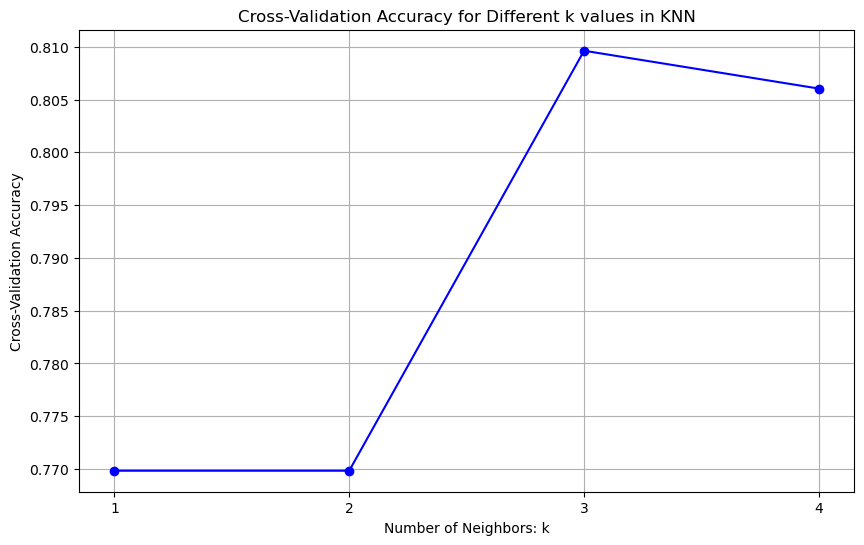

Best k: 3 with Cross-Validation Accuracy: 0.8096


In [14]:
k_value = range(1,5)
k_ = knn.cross_validation_k(X_train,y_train,k_value)

In [15]:
k_real = kNNClassifier(k=k_)

In [16]:
X_test.shape, y_test.shape

((836, 8), (836,))

In [17]:
k_real.fit(X_test, y_test)

In [18]:
prediction = k_real.predict(X_test)

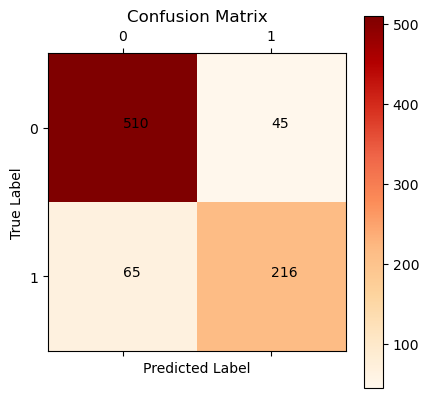

[[510  45]
 [ 65 216]]
Accuracy: 0.868
Recall: 0.7686832740213523
Precision: 0.8275862068965517
F1 Score: 0.7970479704797048


In [19]:
metrics_ = ConfusionMatrix(y_test, prediction)
confusion = metrics_.confusion_matrix()

acc = metrics_.accuracy()
print(f'Accuracy: {acc}')

recall = metrics_.recall()
print(f'Recall: {recall}')

prec = metrics_.precision()
print(f'Precision: {prec}')

f1 = metrics_.f1_score()
print(f'F1 Score: {f1}')